In [1]:
# import tensorflow
# import torch
# import torchvision

# print(tensorflow.__version__)
# print(torch.__version__)
# print(torchvision.__version__)

# !python  --version

# !wget https://www.python.org/ftp/python/3.7.7/Python-3.7.7.tgz
# !tar xvfz Python-3.7.7.tgz
# !Python-3.7.7/configure
# !make
# !sudo make install

# !python --version

In [2]:
!pip3 install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
!git clone https://github.com/qkrwjdduf159/TACO.git

  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-t8s27z44
  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-t8s27z44
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264156 sha256=40bb9b0357d2cc467a37331087d1c9b24233d6be8c50774d63cfb0cbb71a44d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-jb65v4p6/wheels/6b/c6/c5/cb6da4cb793a6cb1ab91f6578d76c42686422127eb4dbcea94
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
Cloning into 'TACO'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 472 (delta 147), reused 123 (delta 71), pack-reused 270
Receiving objects: 100% (472/472), 68.25 MiB | 6.90 MiB/s, done.
Resolving deltas

In [3]:
!pip3 install -r /content/TACO/requirements.txt

In [4]:
# !pip uninstall Pillow
!pip install Pillow

!python3 /content/TACO/download.py --dataset_path '/content/TACO/data/annotations.json'

Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished


## Mask R-CNN and Dataset Processing Inspector

In [5]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

os.chdir('/content/TACO/detector')
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0
import utils
import visualize
from visualize import display_images
import model as modellib
from config import Config
from model import log

     |████████████████████████████████| 92.6 MB 38 kB/s 
     |████████████████████████████████| 367 kB 75.0 MB/s 
     |████████████████████████████████| 3.2 MB 93.3 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [15]:
import csv
import dataset

# Load class map - these tables map the original TACO classes to your desired class system
# and allow you to discard classes that you don't want to include.
class_map = {}
with open("./taco_config/map_4.csv") as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]:row[1] for row in reader}

!python3  /content/TACO/detector/split_dataset.py --dataset_dir '/content/TACO/data' --nr_trials 3

# Load full dataset or a subset
TACO_DIR = "/content/TACO/data"
round = None # Split number: If None, loads full dataset else if int > 0 selects split no 
subset = "train" # Used only when round !=None, Options: ('train','val','test') to select respective subset
dataset = dataset.Taco()
taco = dataset.load_taco(TACO_DIR, round, subset, class_map=class_map, return_taco=True)

# Must call before using the dataset
dataset.prepare()

print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

creating index...
index created!
Number of images used: 1500
Class Count: 5
  0. BG                                                
  1. Bottle                                            
  2. Can                                               
  3. Other                                             
  4. Plastic bag + wrapper                             


In [16]:
class TacoTestConfig(Config):
    NAME = "taco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3
    NUM_CLASSES = dataset.num_classes
config = TacoTestConfig()

In [17]:
%matplotlib inline
import imgaug as ia
from imgaug import augmenters as iaa
import imageio

#ia.seed(1)
nr_augmentations = 10

# Load random image
image_id = np.random.choice(len(dataset.image_ids))
image = dataset.load_image(image_id)
mask, _ = dataset.load_mask(image_id)

# Define our augmentation pipeline.
seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
        iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
        # iaa.Dropout([0.0, 0.05], name='Dropout'), # drop 0-5% of all pixels
        iaa.Fliplr(0.5),
        iaa.Add((-20, 20),name="Add"),
        iaa.Multiply((0.8, 1.2), name="Multiply"),
        iaa.Affine(scale=(0.8, 2.0)),
        iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
        iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
    ], random_order=True)

# Change activated augmentors for masks
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["Blur", "AWGN", "Add","Multiply"]:
        return False
    else:
        # default value for all other augmenters
        return default
    
hooks_masks = ia.HooksImages(activator=activator_masks)

# Initialize the matplotlib figure
fig, aux = plt.subplots(ncols=2, nrows=nr_augmentations+1, figsize=(15,60))

aux[0,0].imshow(image)
aux[0,0].axis('off')
aux[0,1].imshow(mask.sum(axis=2)) # form an unique segmask from multiple masks
aux[0,1].axis('off')

print('This may take some time, as we are working with the original image size...')

# Augment images and masks
for i in range(nr_augmentations):
    seq_det = seq.to_deterministic()
    image_augmented = seq_det.augment_image(image)
    mask_augmented = seq_det.augment_image(mask.astype(np.uint8), hooks=hooks_masks)
    seg_mask = mask_augmented.sum(axis=2)

    aux[i+1,0].imshow(image_augmented)
    aux[i+1,0].axis('off')
    aux[i+1,1].imshow(seg_mask)
    aux[i+1,1].axis('off')
    
    
plt.subplots_adjust(wspace=0.2, hspace=0)

Output hidden; open in https://colab.research.google.com to view.

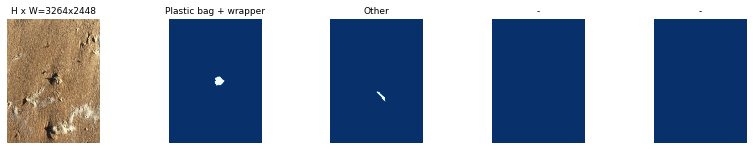

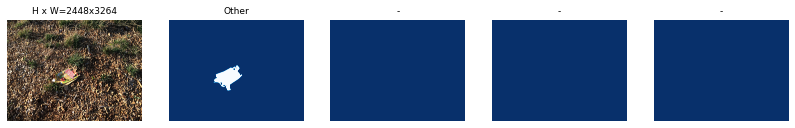

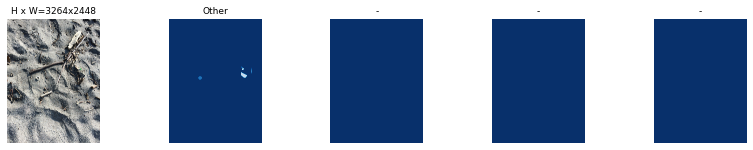

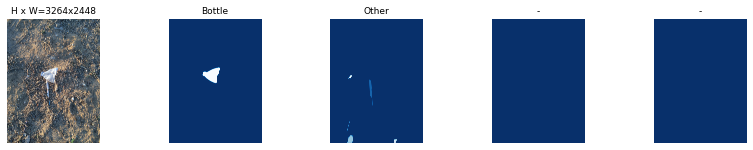

In [18]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

[3 4]
image_id  823 
image                    shape: (3264, 2448, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (3264, 2448, 2)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    3.00000  max:    4.00000  int32
bbox                     shape: (2, 4)                min:  286.00000  max: 2647.00000  int32


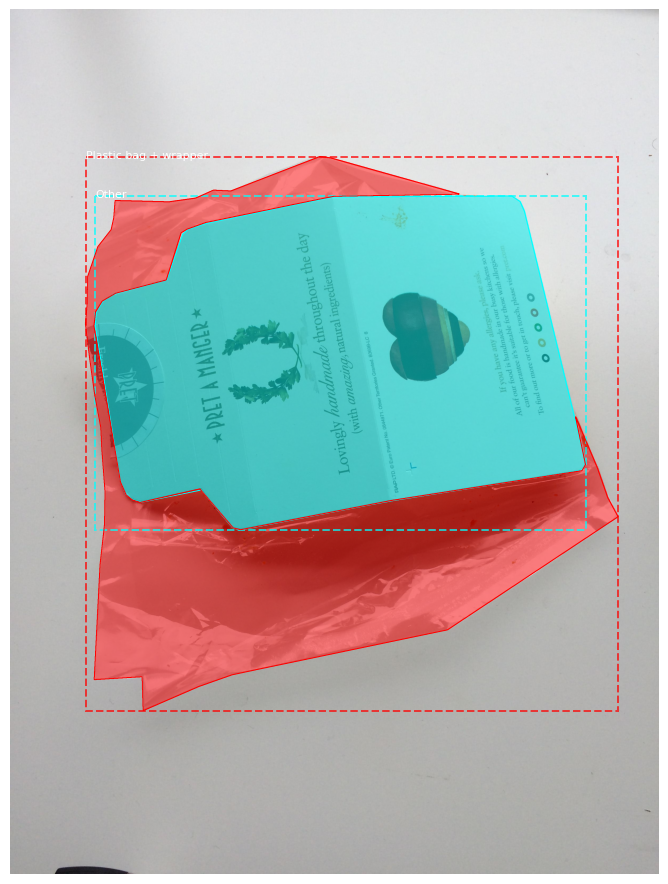

In [19]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
print(class_ids)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  824 
Original shape:  (2448, 3264, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
mask                     shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    3.00000  max:    4.00000  int32
bbox                     shape: (2, 4)                min:  138.00000  max:  858.00000  int32


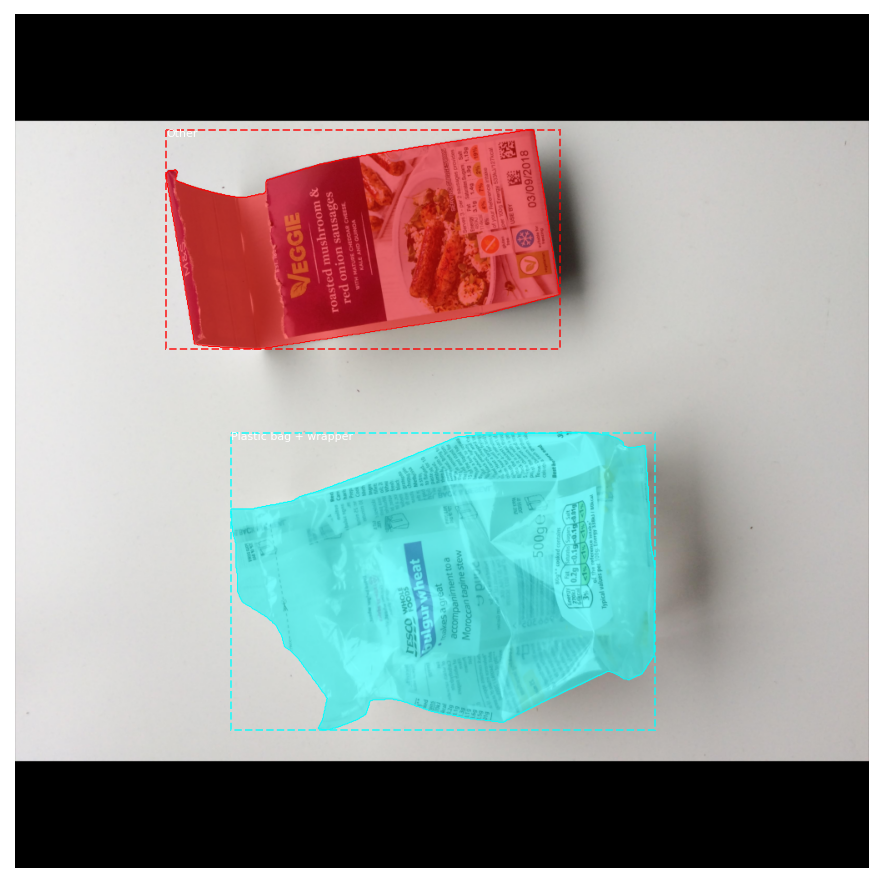

In [20]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 4000.00000  int64
class_ids                shape: (5,)                  min:    3.00000  max:    4.00000  int32
bbox                     shape: (5, 4)                min:  120.00000  max: 1024.00000  int32
mask                     shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


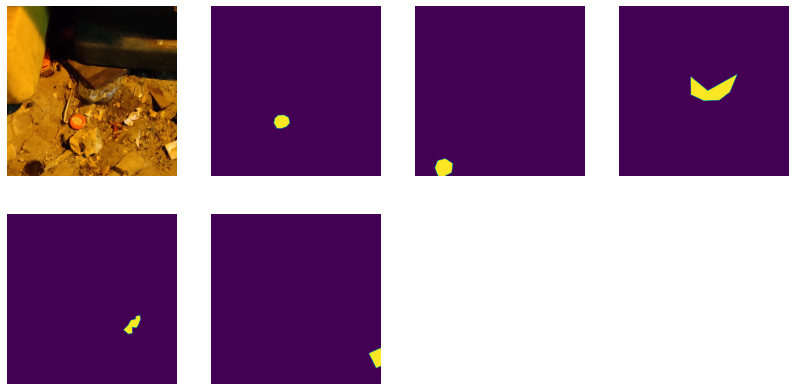

In [21]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

## 다시

In [23]:
os.chdir('/content')
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 31.95 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [24]:
!git clone https://github.com/Youngpyoryu/detect-waste.git

Cloning into 'detect-waste'...
remote: Enumerating objects: 928, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 928 (delta 71), reused 80 (delta 36), pack-reused 766
Receiving objects: 100% (928/928), 85.18 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [26]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=58e2eacbf63a4e67c2b16ec0c57ce21b9293933520082411575ba611c5886aaa
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [36]:
import torch
torch.__version__

'1.9.0+cu111'

In [41]:
!pip install funcy
!pip install iterative-stratification==0.1.6

Traceback (most recent call last):
  File "/content/detect-waste/annotations_preprocessing.py", line 58, in <module>
    dest=args.detectwaste_dest)
  File "/content/detect-waste/utils/dataset_converter.py", line 94, in taco_categories_to_detectwaste
    with open(source, 'r') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/dih4/dih4_2/wimlds/TACO-master/data/annotations.json'


In [65]:
os.chdir('/content/detect-waste/MaskRCNN')
# !pip3 install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

!python3 train.py --output_dir '/content' --images_dir '/content/TACO/data' --anno_name '/content/detect-waste/annotations/annotations' --gpu_id 2 --num_classes 7

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Start training
Traceback (most recent call last):
  File "train.py", line 223, in <module>
    train_one_epoch(model, optimizer, data_loader,
  File "/content/detect-waste/MaskRCNN/engine.py", line 35, in train_one_epoch
    header):
  File "/content/detect-waste/MaskRCNN/utils.py", line 201, in log_every
    for obj in iterable:
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1229, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.7/dist-packages/torch/_utils.py", line 425, in reraise
    raise self.ex

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as T
from matplotlib import pyplot as plt

# 모델이 있는 장소
PATH = ''

# 이미지 장소
IMG_NAME = ''

NUM_CLASSES = 7
THRESHOLD = 0.8

# class 나눠주기
CLASSES = ['']

transforms = T.Compose([
                        T.ToTensor()
])

